# Exploring the Dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

In [2]:
path = '/home/eduardo/Desktop/Proyecto/Philadelphia/'
file = 'crime_philadelpia_20062019.csv'

In [ ]:
df = pd.read_csv(path+file,index_col='dispatch_date',parse_dates=True)

In [ ]:
df.head()

In [ ]:
df['dc_dist'].unique()

In [ ]:
df.info()

In [ ]:
df.isnull().sum()

In [ ]:
df2 = df.groupby(pd.Grouper(freq="M")).count()
df2.index.freq ='M'

In [ ]:
df2.shape

In [ ]:
df2 = df2.iloc[:160]

In [ ]:
df2['dc_dist'].plot(figsize=(12,6),grid=True);

### 1. Error Trend Seasonality

In [ ]:
# model = 'additive' 'multiplicative'
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df2['dc_dist'],model='add')
from pylab import rcParams
rcParams['figure.figsize'] = 12,6
result.plot(); 

In [ ]:
df2['dc_dist'].iloc[:36].plot(figsize=(12,6));

### 2. Pyramid ARIMA

In [ ]:
# Non Stationary Dataset
from pmdarima import auto_arima
# In this case the dataset has seasonality and m is every year = 12
stepwise_fit = auto_arima(df2['dc_dist'],seasonal=True,trace=True,m=12)
print(stepwise_fit)
# Best Model
stepwise_fit.summary()

In [ ]:
ste

### 3. Train Test Split

In [100]:
len(df2)

160

In [141]:
train = df2.iloc[:148]
test= df2.iloc[148:]

### 4. SARIMA Model

In [142]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model = SARIMAX(train['dc_dist'],order=(1,1,0),seasonal_order=(1, 0, 1, 12)) # enforce_invertibility=False
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                            dc_dist   No. Observations:                  148
Model:             SARIMAX(1, 1, 0)x(1, 0, 1, 12)   Log Likelihood               -1219.538
Date:                            Sat, 04 May 2019   AIC                           2447.077
Time:                                    17:27:26   BIC                           2459.038
Sample:                                01-31-2006   HQIC                          2451.937
                                     - 04-30-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2699      0.040     -6.703      0.000      -0.349      -0.191
ar.S.L12       0.9380      0.030     30.794      0.000       0.878       0.998
ma.S.L12      -0.7401      0.066    -11.169      0.000      -0.870      -0.610
sigma2      7.308e+05   7.97e+04      9.170      0.000    5.75e+05    8.87e+05
===================================================================================
Ljung-Box (Q):                       71.00   Jarque-Bera (JB):                27.97
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.42   Skew:                            -0.66
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### 5. Predictions

In [143]:
start = len(train)
end = len(train) + len(test) - 1
# typ= 'levels' to return the differenced values to the original units
preds = results.predict(start=start,end=end,typ='levels').rename('SARIMA (1,1,0)(2,0,1,12) Predictions')

/home/eduardo/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:320: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)


### 6. Plotting

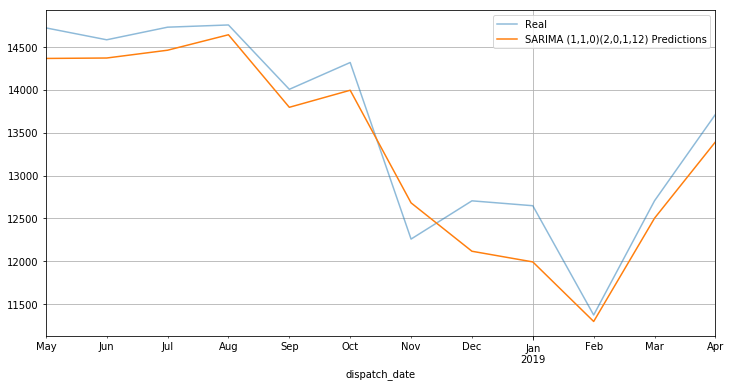

In [144]:
test['dc_dist'].plot(figsize=(12,6),legend=True,alpha=0.5,label='Real')
preds.plot(legend=True,alpha=1)
plt.grid(True);

### 7. Evaluate the Model

In [145]:
from statsmodels.tools.eval_measures import rmse
error = rmse(test['dc_dist'],preds) # Compare it with test.mean()
error

354.7352465983601

In [146]:
test['dc_dist'].mean()

13544.666666666666

### 8. Forecast for Future Data

In [147]:
# Refit with all the Data
model = SARIMAX(df2['psa'],order=(1,1,0),seasonal_order=(1, 0, 1, 12)) # Order is chosen from Pyramid ARIMA
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                psa   No. Observations:                  160
Model:             SARIMAX(1, 1, 0)x(1, 0, 1, 12)   Log Likelihood               -1316.845
Date:                            Sat, 04 May 2019   AIC                           2641.690
Time:                                    17:27:33   BIC                           2653.966
Sample:                                01-31-2006   HQIC                          2646.675
                                     - 04-30-2019                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2936      0.042     -7.011      0.000      -0.376      -0.212
ar.S.L12       0.9978      0.009    105.508      0.000       0.979       1.016
ma.S.L12      -0.9562      0.094    -10.119      0.000      -1.141      -0.771
sigma2      6.703e+05   8.94e-08    7.5e+12      0.000     6.7e+05     6.7e+05
===================================================================================
Ljung-Box (Q):                       97.34   Jarque-Bera (JB):                16.06
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.36   Skew:                            -0.55
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.10
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.39e+28. Standard errors may be unstable.
"""

/home/eduardo/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:320: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)


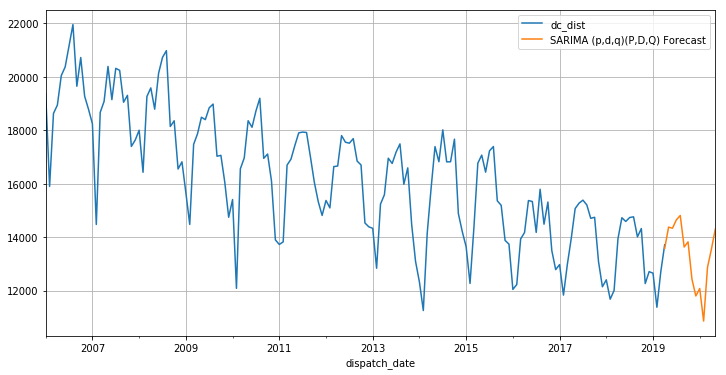

In [149]:
# Forecasting
start = len(df2) - 1 
end = len(df2) + 12
# typ= 'levels' to return the differenced values to the original units
forecasted_values = results.predict(start=start,end=end,typ='levels').rename('SARIMA (p,d,q)(P,D,Q) Forecast')
# Plotting
df2['dc_dist'].plot(figsize=(12,6),legend=True)
forecasted_values.plot(legend=True)
plt.grid(True);